In [1]:
import string, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def readtxt(file_name): 
        file = open(file_name, mode='rt', encoding='utf-8')  
        text = file.read() 
        file.close() 
        return text
    
def splitter(text): 
    temp = text.strip().split('\n') 
    splitted = [i.split('\t') for i in temp] 
    return splitted

def prepper(text):
    punc = [".","]","[","!","?","'",","]
    for s in punc:
        text = text.replace(s,"")
    return text.lower()

def tokenization(lines): 
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(lines) 
    return tokenizer
    
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)          
    seq = pad_sequences(seq,
                     maxlen = length, 
                     padding = 'post')           
    return seq

def get_word(n, tokenizer):  
    for word, index in tokenizer.word_index.items():                       
    if index == n: 
        return word 
    return None

In [3]:
rawdata = readtxt('deu.txt')
dataset = np.array(splitter(rawdata))
dataset = dataset[:50000,:]

In [4]:
deu_eng = []
for k in range(len(dataset)):
    deu_eng.append(prepper(str(dataset[k])).split(";"))

In [5]:
ENG = []
DEU = []
for p in range(len(deu_eng)):
    ENG.append(deu_eng[p][0])
    DEU.append(deu_eng[p][1])

       eng  deu
0        1    1
1        1    1
2        1    2
3        1    1
4        1    1
...    ...  ...
49995    5    7
49996    4    5
49997    4    4
49998    4    5
49999    4    4

[50000 rows x 2 columns]


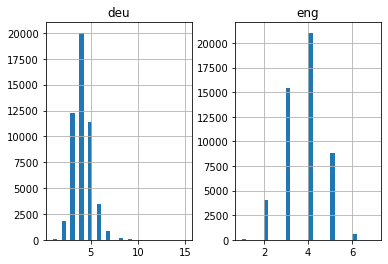

In [6]:
eng_word_count = []
deu_word_count = []

for i in ENG:
    eng_word_count.append(len(i.split()))

for j in DEU:
    deu_word_count.append(len(j.split()))

length_df = pd.DataFrame({'eng':eng_word_count, 
                          'deu':deu_word_count})
print(length_df)
length_df.hist(bins = 30) 
plt.show()

In [7]:
length_df.max()

eng     7
deu    15
dtype: int64

In [8]:
eng_tokenizer = tokenization(ENG) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

deu_tokenizer = tokenization(DEU) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 16

In [9]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(deu_eng,
                               test_size = 0.2,
                               random_state = 12)

ENG_train = []
ENG_test = []
DEU_train = []
DEU_test = []

for w in range(len(train)):
    ENG_train.append(train[w][0])
    DEU_train.append(train[w][1])
    
for w in range(len(test)):
    ENG_test.append(test[w][0])
    DEU_test.append(test[w][1])
    
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, DEU_train) 
trainY = encode_sequences(eng_tokenizer, eng_length, ENG_train) 

# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, DEU_test) 
testY = encode_sequences(eng_tokenizer, eng_length, ENG_test)

In [14]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, 
                          n, 
                          input_length = in_timesteps,   
                          mask_zero = True)
               ) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [15]:
# model compilation (with 512 hidden units)
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [96]:
training_session = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, verbose=1)

Epoch 1/30
63/63 [==============================] - 159s 3s/step - loss: 3.4299 - val_loss: 2.8750
Epoch 2/30
63/63 [==============================] - 166s 3s/step - loss: 2.7918 - val_loss: 2.7874
Epoch 3/30
63/63 [==============================] - 163s 3s/step - loss: 2.6324 - val_loss: 2.5847
Epoch 4/30
63/63 [==============================] - 164s 3s/step - loss: 2.4498 - val_loss: 2.4460
Epoch 5/30
63/63 [==============================] - 164s 3s/step - loss: 2.3039 - val_loss: 2.3614
Epoch 6/30
63/63 [==============================] - 164s 3s/step - loss: 2.1755 - val_loss: 2.2416
Epoch 7/30
63/63 [==============================] - 167s 3s/step - loss: 2.0577 - val_loss: 2.1596
Epoch 8/30
63/63 [==============================] - 164s 3s/step - loss: 1.9428 - val_loss: 2.1111
Epoch 9/30
63/63 [==============================] - 165s 3s/step - loss: 1.8430 - val_loss: 2.0123
Epoch 10/30
63/63 [==============================] - 164s 3s/step - loss: 1.7432 - val_loss: 1.9663
Epoch 11/

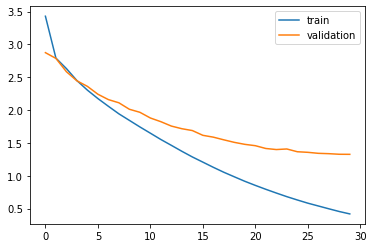

In [98]:
plt.plot(training_session.history['loss']) 
plt.plot(training_session.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

In [97]:
# save model in json file and its weight
model_json = model.to_json()
with open("model_DEU_ENG.json","w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_DEU_ENG.h5")

print("Model and weight saved in local computer")

Model and weight saved in local computer


In [10]:
from keras.models import model_from_json

# load model in json file and its weight
json_file = open('model_DEU_ENG.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_DEU_ENG.h5")

print("Model and weight loaded")

loaded_model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model and weight loaded


In [11]:
preds = loaded_model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
preds_text = [] 
for i in preds:        
    temp = []        
    for j in range(len(i)):             
        t = get_word(i[j], eng_tokenizer)             
        if j > 0:                 
            if (t == get_word(i[j-1],eng_tokenizer)) or (t== None):                       
                 temp.append('')                 
            else:                      
                 temp.append(t)             
        else:                    
            if(t == None):                                   
                 temp.append('')                    
            else:                           
                 temp.append(t)        
    preds_text.append(' '.join(temp))

In [14]:
pred_df = pd.DataFrame({'Sources Sentences'              : DEU_test,
                        'Predicted Translated Sentences' : preds_text,
                        'Actual Translated Sentences'    : ENG_test})
pred_df.head()

,Sources Sentences,Predicted Translated Sentences,Actual Translated Sentences
0,es kann nicht lange dauern,it cant take my,it cannot last long
1,liege ich richtig,i right,am i right
2,rate wer ich bin,think who i,guess who i am
3,"wir sind in der stadt""",were in the,"""were in town"
4,tom kann am schnellsten laufen,tom is a bread,tom runs the fastest


In [15]:
pred_df.to_csv('Translated_DEU_to_ENG.csv',index=False)